# Drug information
- Supplementary Figure 2

In [1]:
import pandas as pd
import time
import os
import glob
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
from scipy.stats import binomtest


print("pandas",pd.__version__)
print("numpy",np.__version__)
print("matplotlib",mpl.__version__)
print("scipy",scipy.__version__)

### setup ###
# Data Directory
current_path = "/Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/"
output_image_dir = current_path +"NephroticSyndrome_image/"
if not os.path.exists(output_image_dir):
    os.mkdir(output_image_dir)

mpl.style.use("default")
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42 
mpl.rcParams['ps.fonttype'] = 42

pandas 1.3.4
numpy 1.22.4
matplotlib 3.6.3
scipy 1.7.3


In [2]:
# Date infromation of indicviduals in both group
use_cols= ["Enrollee ID","Observation_start_yyyymm","Observation_end_yyyymm","Target_diag_yyyymm"]
df_p = pd.read_csv(current_path+"NephroticSyndrome_csv/patient/individuals.csv",
                  usecols=use_cols)
df_c = pd.read_csv(current_path+"NephroticSyndrome_csv/control/individuals.csv",
                  usecols=use_cols)
df_p["Target"]=1
df_c["Target"]=0

df = pd.concat([df_p,df_c]).drop_duplicates("Enrollee ID")

# To the observation start from target diagnosis
df["To_observation_start"]= pd.to_datetime(df["Observation_start_yyyymm"],format='%Y%m').dt.to_period('M').view('int')-pd.to_datetime(
                                        df["Target_diag_yyyymm"],format='%Y%m').dt.to_period('M').view('int')
# To the observation end from target diagnosis
df["To_observation_end"] = pd.to_datetime(df["Observation_end_yyyymm"],format='%Y%m').dt.to_period('M').view('int')-pd.to_datetime(
                                        df["Target_diag_yyyymm"],format='%Y%m').dt.to_period('M').view('int')
df.head()

,Enrollee ID,Observation_start_yyyymm,Observation_end_yyyymm,Target_diag_yyyymm,Target,To_observation_start,To_observation_end
0,M000051963,201101,201903,201411,1,-46,52
1,M000055609,201203,201903,201504,1,-37,47
2,M000084358,200501,201903,201502,1,-121,49
3,M000355777,201204,201803,201803,1,-71,0
4,M000369339,200501,201903,201505,1,-124,46


In [3]:
# Data
df_drug = pd.read_csv(current_path+"NephroticSyndrome_csv/Drugs.csv")

# English tanslation dictionary
eng_dict ={
     "加入者ID": "Enrollee ID",
     "レセID":"Receipt_ID", 
     "明細ID":"Detail_ID", 
     "レセ種別":"Receipt_Type", 
     "診療年月":"Record_yyyymm", 
     "医療施設ID":"Facility_ID", 
     "ATC大分類コード":"ATC_Major_Code", 
     "ATC大分類名":"ATC_Major_Name", 
     "ATC中分類コード":"ATC_Intermediate_Code", 
     "ATC中分類名":"ATC_Intermediate_Name", 
     "ATC小分類コード":"ATC_Minor_Code", 
     "ATC小分類名":"ATC_Minor_Name", 
     "ATC細分類コード":"ATC_Fine_Code", 
     "ATC細分類名":"ATC_Fine_Name", 
     "WHO-ATCコード":"WHO-ATC_Code", 
     "WHO-ATC名":"WHO-ATC_Name", 
     "薬価基準収載医薬品コード":"Standard_Listed_Code", 
     "個別12桁コード":"Individual_12-digit_Code", 
     "レセプト電算コード":"Receipt_Computer_Code", 
     "成分名":"Ingredient_Name", 
     "ブランド名":"Brand_Name", 
     "医薬品コード":"Drug_Code", 
     "医薬品名":"Drug_Name", 
     "規格単位":"Standard_Unit", 
     "後発品フラグ":"Generic_Flag", 
     "薬価":"Drug_Price", 
     "処方日":"Prescription_yyyymmdd", 
     "調剤日":"Dispensing_yyyymmdd", 
     "1処方あたりの1日投与量":"Daily_Dose", 
     "投与量単位":"Dosage_Unit", 
     "1処方あたりの投与日数":"Dosing_Days_per_Prescription", 
     "投薬量":"Amount", 
     "剤形大分類名":"Formulation_Major_Name", 
     "剤形中分類名":"Formulation_Intermediate_Name", 
     "剤形小分類名":"Formulation_Minor_Name", 
     "同時ID":"Simultaneous_ID", 
     "頓服フラグ":"Potion_Flag", 
     "診療区分":"Medical_Category", 
     "調剤料":"Dispensing_Fee", 
     "薬剤料":"Drug_Fee", 
     "加算料":"Additional_Fee", 
     "レセプト記載点数":"Receipt_Points"
}

# Limit columns used
df_drug= df_drug.rename(columns = eng_dict)[[
    "Enrollee ID",
    "Record_yyyymm",
    "Prescription_yyyymmdd",
    "Dispensing_yyyymmdd",
    "ATC_Intermediate_Code",
    "WHO-ATC_Code",
    "Drug_Name"
]]
# Add group labels and diagnosis date
df_drug= df_drug.merge(df,how="left",on="Enrollee ID")

In [4]:
# To prescription from target diagnosis
# We used "Record_yyyymm" to avoid NaN in "Prescription_yyyymmdd"
df_drug["Month_from_target_diag"]= pd.to_datetime(df_drug["Record_yyyymm"],format='%Y%m').dt.to_period('M').view('int')-pd.to_datetime(
                                        df_drug["Target_diag_yyyymm"],format='%Y%m').dt.to_period('M').view('int')

In [5]:
import itertools

time_points = np.arange(start =df_drug["To_observation_start"].min(),
                        stop=df_drug["To_observation_end"].max()+1)


# Drug codes of interest
codes = ["H02","C09","M04","C10"]

# We used EPHMRA's ATC codes for our analysis (This code is product-based) to calculate a cumnulative prescription
df_temp = df_drug[["Enrollee ID","ATC_Intermediate_Code","Month_from_target_diag","To_observation_end","Target"]].copy()
df_temp.sort_values(by = "Month_from_target_diag",kind="mergesort",ascending=True, inplace=True)
df_temp.drop_duplicates(subset=["Enrollee ID","ATC_Intermediate_Code"],keep="first", inplace=True)

# Extract prescriptions of interest
df_temp = df_temp[df_temp["ATC_Intermediate_Code"].isin(codes)]

# Multi-level for counting 
# We made a column for each code and each ID, which was set up with a hierarchy of groups
array = [x for x in itertools.product(["Control"],codes,df_c["Enrollee ID"].drop_duplicates())
        ] + [x for x in itertools.product(["Case"],codes,df_p["Enrollee ID"].drop_duplicates())
            ]
column = pd.MultiIndex.from_tuples(array, names=["Group", "Drug", "ID"])



# Dataframe for counting
df_count = pd.DataFrame(index=time_points,columns=column)

# Label firts prescription point of each drug
for group in ["Control", "Case"]:
    # Extract group data
    if group == "Control":
        df_group_temp = df_temp[df_temp["Target"]==0]
    elif group == "Case":
        df_group_temp = df_temp[df_temp["Target"]==1]

    for code in codes:
        df_code_temp = df_group_temp.loc[(df_group_temp["ATC_Intermediate_Code"]==code)].copy()

        for row in df_code_temp.iterrows():
            # Prescription timepoint
            df_count.loc[row[1]["Month_from_target_diag"],(group,code,row[1]["Enrollee ID"])]=1
            # Observation end timepoint
            df_count.loc[row[1]["To_observation_end"],(group,code,row[1]["Enrollee ID"])]=0


# Label timepoints from a prescription, to an observation end
df_count.ffill(inplace = True)
df_count.fillna(0,inplace = True)

In [6]:
# Combinations of interest
code2 = ["M04*C09*C10", "C09*C10", "M04*C09", "M04*C10"]
# For combination
array = [x for x in itertools.product(["Control"],code2,df_c["Enrollee ID"].drop_duplicates())
        ] + [x for x in itertools.product(["Case"],code2,df_p["Enrollee ID"].drop_duplicates())
            ]
column = pd.MultiIndex.from_tuples(array, names=["Group", "Drug", "ID"])
# Dataframe for counting
df_comb = pd.DataFrame(index=time_points,columns=column)

# Count each combination of interest
for group in ["Control", "Case"]:
    if group == "Control":
        idx = df_c["Enrollee ID"].drop_duplicates()      
    elif group == "Case":
        idx = df_p["Enrollee ID"].drop_duplicates()  
    for i in idx:
        df_comb.loc[:,(group,"M04*C10",i)]=df_count.loc[:,(group,"M04",i)]*df_count.loc[:,(group,"C10",i)]
        df_comb.loc[:,(group,"M04*C09",i)]=df_count.loc[:,(group,"M04",i)]*df_count.loc[:,(group,"C09",i)]
        df_comb.loc[:,(group,"C09*C10",i)]=df_count.loc[:,(group,"C09",i)]*df_count.loc[:,(group,"C10",i)]
        df_comb.loc[:,(group,"M04*C09*C10",i)]=df_count.loc[:,(group,"M04",i)]*df_comb.loc[:,(group,"C09*C10",i)]

In [7]:
# Counts individuals at time_points for a calculation of ratio

# Individual observation period. Some hadn't been prescribed, so we should use original dataframe not df_drug
df_temp =df[['Enrollee ID','Target','To_observation_start', 'To_observation_end']].drop_duplicates()

case_con = {"Case":1,"Control":0}
df_obsnum = pd.DataFrame(data = {"Time_point":time_points})
for key in case_con.keys():
    for i in range(len(df_obsnum)-1):
        start_mask = (df_temp["Target"]==case_con[key])&(df_temp["To_observation_start"]<=df_obsnum.loc[i, "Time_point"])
        end_mask = (df_temp["Target"]==case_con[key])&(df_obsnum.loc[i+1, "Time_point"]<=df_temp["To_observation_end"])
        df_obsnum.loc[i, f"{key}"] = (start_mask&end_mask).sum()

    end_mask = (df_temp["Target"]==case_con[key])&(df_obsnum.loc[len(df_obsnum)-1, "Time_point"] <= df_temp["To_observation_end"])
    df_obsnum.loc[len(df_obsnum)-1, f"{key}"] = end_mask.sum()
df_obsnum.set_index("Time_point",inplace=True)

In [8]:
# Aggregate counts and then concatenate two dataframes
df_total = pd.concat([df_count.T.groupby(level=("Group","Drug")).agg(sum),
                      df_comb.T.groupby(level=("Group","Drug")).agg(sum)]).sort_index()

# Calculate ratios along with time
df_ratio = pd.concat([df_total.loc["Case"]/df_obsnum["Case"],
                      df_total.loc["Control"]/df_obsnum["Control"]],keys=("Case","Control")).T

## Cumulative proportion 

In [9]:
# This is an ATC code dictionary in English
df_atc = pd.read_excel("/Users/chidakatsuyuki/Desktop/Project/ref_data/ATC_codes.xlsx", "Second")
df_atc["description"] =df_atc["description"].str.capitalize()
df_atc.set_index("code",inplace = True)

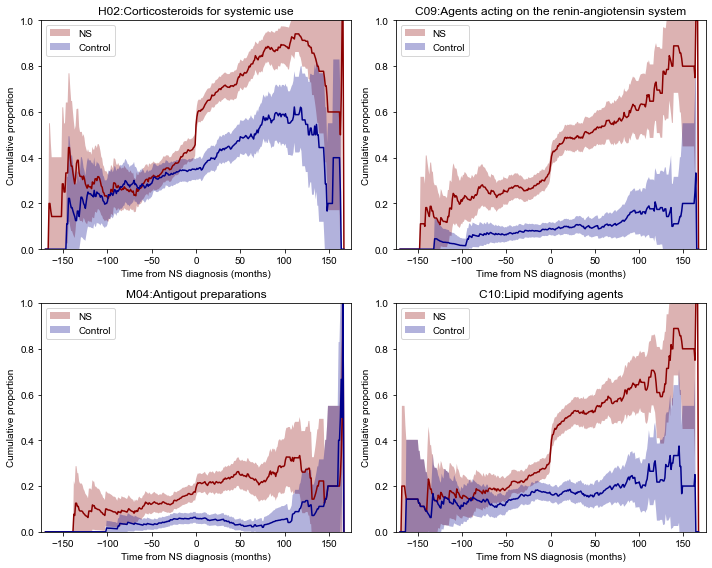

In [10]:
# Plot cumulative prescription ratio
from scipy.stats import norm
z_crit = [norm.ppf(0.025), norm.ppf(0.975)]
codes = ["H02", "C09","M04","C10"]
color_dict ={"Control":"darkblue", "Case": "darkred"}
df_prop = pd.DataFrame(index=time_points,
                       columns=pd.MultiIndex.from_product((["Case","Control"],codes,["Ratio","Upper","Lower"])))

fig, ax = plt.subplots(2,2,figsize = (10, 8))
ax = ax.ravel()
for i,code in enumerate(codes):
    for group in ["Case","Control"]:
        ps = df_ratio.loc[:,(group,code)]
        df_prop.loc[:,(group,code,"Ratio")] = ps
        # 95%CI (Wald method)
        df_prop.loc[:,(group,code,"Upper")] = ps + z_crit[0]*np.sqrt(ps*(1-ps)/df_obsnum[group])
        df_prop.loc[:,(group,code,"Lower")] = ps + z_crit[1]*np.sqrt(ps*(1-ps)/df_obsnum[group])
        ax[i].fill_between(df_prop.index, "Upper", "Lower", data=df_prop[group][code],
                           facecolor=color_dict[group], alpha=0.3, label='fill')
        # Plot
        ax[i].plot(df_prop[group][code]["Ratio"],c = color_dict[group])
        
    #Layout
    hans, labs = ax[i].get_legend_handles_labels()
    ax[i].set_title(f'{code}:{df_atc.loc[code,"description"]}')
    ax[i].set_ylabel("Cumulative proportion")
    ax[i].set_ylim([0,1])
    ax[i].set_xlim([-175,175])
    ax[i].legend(handles = [hans[0], hans[1]],labels = ["NS","Control"])
    ax[i].set_xlabel("Time from NS diagnosis (months)")
    ax[i].set_xticks([-150,-100,-50,0,50,100,150])
plt.tight_layout()

## Odds for prescription combination

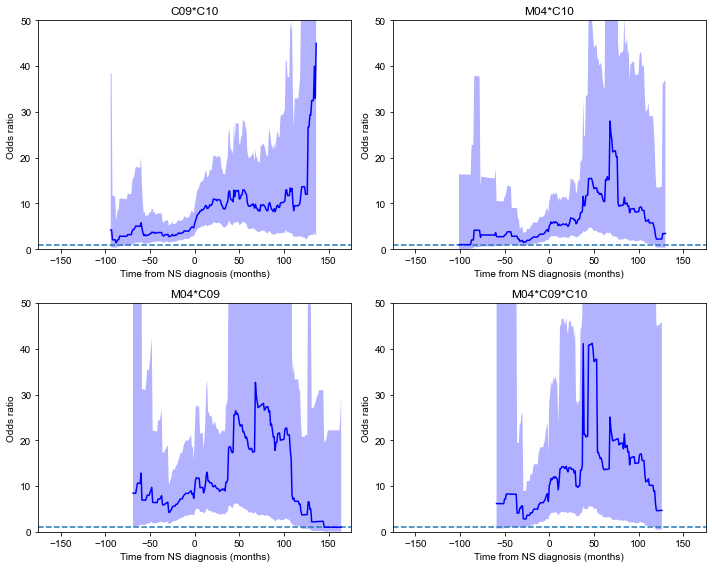

In [11]:
code2 = ["C09*C10","M04*C10","M04*C09","M04*C09*C10"]
df_odds = pd.DataFrame(index=time_points,
                       columns=pd.MultiIndex.from_product((code2,["Ratio","Upper","Lower"])))

fig, ax = plt.subplots(2,2,figsize = (10, 8))
ax = ax.ravel()

for i,code in enumerate(code2):
    # Items in cross table
    a = df_total.T["Case"][code]
    b = df_obsnum["Case"]-df_total.T["Case"][code]
    c = df_total.T["Control"][code]
    d = df_obsnum["Control"]-df_total.T["Control"][code]
    
    # Odds calculation
    df_odds.loc[:,(code,"Odds")] = (a*d)/(b*c)
    df_odds.loc[:,(code,"Upper")] = df_odds.loc[:,(code,"Odds")]*np.exp(z_crit[1]*np.sqrt(1/a+1/d+1/c+1/b))
    df_odds.loc[:,(code,"Lower")] = df_odds.loc[:,(code,"Odds")]*np.exp(z_crit[0]*np.sqrt(1/a+1/d+1/c+1/b))
    
    # Plot
    ax[i].set_ylim([0,50])
    ax[i].hlines(y=1,xmin=-175,xmax=175,linestyles='dashed')
    ax[i].fill_between(df_odds.index, 
                    df_odds.loc[:,(code,"Lower")],
                     df_odds.loc[:,(code,"Upper")],
                    facecolor="blue", alpha=0.3, label='fill')
    ax[i].plot(df_odds.loc[:,(code,"Odds")],c = "blue")
    ax[i].set_ylabel("Odds ratio")
    ax[i].set_title(f"{code}")
    ax[i].set_xlim([-175,175])
    ax[i].set_xlabel("Time from NS diagnosis (months)")
plt.tight_layout()
plt.savefig(output_image_dir+"Drugs_odds_ratio.pdf")

## For other analyses

In [12]:
time_points = np.arange(start =df_drug["To_observation_start"].min(),
                        stop=df_drug["To_observation_end"].max()+1)


# Drug codes of interest
codes = ["C03"]

# We used EPHMRA's ATC codes for our analysis (This code is product-based) to calculate a cumnulative prescription
df_temp = df_drug[["Enrollee ID","ATC_Intermediate_Code","Month_from_target_diag","To_observation_end","Target"]].copy()
df_temp.sort_values(by = "Month_from_target_diag",kind="mergesort",ascending=True, inplace=True)
df_temp.drop_duplicates(subset=["Enrollee ID","ATC_Intermediate_Code"],keep="first", inplace=True)

# Extract prescriptions of interest
df_temp = df_temp[df_temp["ATC_Intermediate_Code"].isin(codes)]

# Multi-level for counting 
# We made a column for each code and each ID, which was set up with a hierarchy of groups
array = [x for x in itertools.product(["Control"],codes,df_c["Enrollee ID"].drop_duplicates())
        ] + [x for x in itertools.product(["Case"],codes,df_p["Enrollee ID"].drop_duplicates())
            ]
column = pd.MultiIndex.from_tuples(array, names=["Group", "Drug", "ID"])



# Dataframe for counting
df_count2 = pd.DataFrame(index=time_points,columns=column)

# Label firts prescription point of each drug
for group in ["Control", "Case"]:
    # Extract group data
    if group == "Control":
        df_group_temp = df_temp[df_temp["Target"]==0]
    elif group == "Case":
        df_group_temp = df_temp[df_temp["Target"]==1]

    for code in codes:
        df_code_temp = df_group_temp.loc[(df_group_temp["ATC_Intermediate_Code"]==code)].copy()

        for row in df_code_temp.iterrows():
            # Prescription timepoint
            df_count2.loc[row[1]["Month_from_target_diag"],(group,code,row[1]["Enrollee ID"])]=1
            # Observation end timepoint
            df_count2.loc[row[1]["To_observation_end"],(group,code,row[1]["Enrollee ID"])]=0


# Label timepoints from a prescription, to an observation end
df_count2.ffill(inplace = True)
df_count2.fillna(0,inplace = True)

# Aggregate counts and then concatenate two dataframes
df_total2 = df_count2.T.groupby(level=("Group","Drug")).agg(sum).sort_index()

# Calculate ratios along with time
df_ratio2 = pd.concat([df_total2.loc["Case"]/df_obsnum["Case"],
                      df_total2.loc["Control"]/df_obsnum["Control"]],keys=("Case","Control")).T

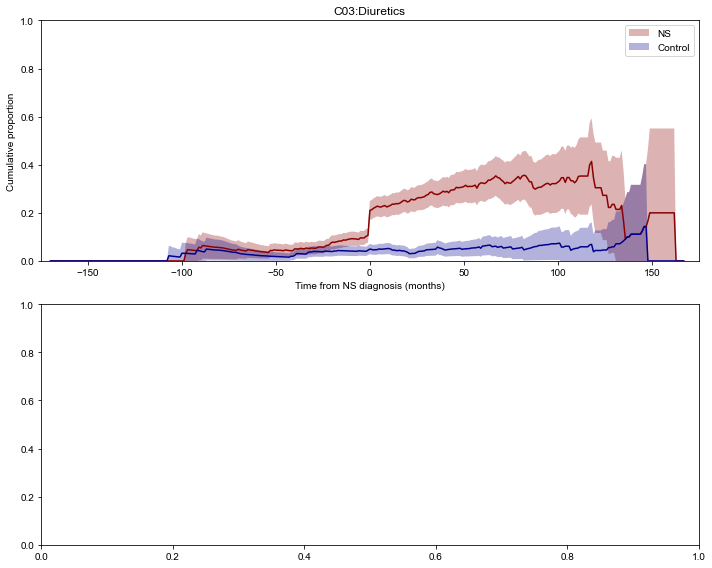

In [13]:
z_crit = [norm.ppf(0.025), norm.ppf(0.975)]
codes = ["C03"]
color_dict ={"Control":"darkblue", "Case": "darkred"}

df_prop = pd.DataFrame(index=time_points,
                       columns=pd.MultiIndex.from_product((["Case","Control"],codes,["Ratio","Upper","Lower"])))

fig, ax = plt.subplots(2,1,figsize = (10, 8))


ax = ax.ravel()
for i,code in enumerate(codes):
    for group in ["Case","Control"]:
        ps = df_ratio2.loc[:,(group,code)]
        
        df_prop.loc[:,(group,code,"Ratio")] = ps
        # 95%CI (Wald method)
        df_prop.loc[:,(group,code,"Upper")] = ps + z_crit[0]*np.sqrt(ps*(1-ps)/df_obsnum[group])
        df_prop.loc[:,(group,code,"Lower")] = ps + z_crit[1]*np.sqrt(ps*(1-ps)/df_obsnum[group])
        ax[i].fill_between(df_prop.index, "Upper", "Lower", data=df_prop[group][code],
                           facecolor=color_dict[group], alpha=0.3, label='fill')
        # Plot
        ax[i].plot(df_prop[group][code]["Ratio"],c = color_dict[group])
        
    #Layout
    hans, labs = ax[i].get_legend_handles_labels()
    ax[i].set_title(f'{code}:{df_atc.loc[code,"description"]}')
    ax[i].set_ylabel("Cumulative proportion")
    ax[i].set_ylim([0,1])
    ax[i].set_xlim([-175,175])
    ax[i].legend(handles = [hans[0], hans[1]],labels = ["NS","Control"])
    ax[i].set_xlabel("Time from NS diagnosis (months)")
    ax[i].set_xticks([-150,-100,-50,0,50,100,150])
plt.tight_layout()